In [1]:
import pandas as pd
import numpy as np
import folium
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, Normalize
import matplotlib.cm as cm

# Comparative Result

In [47]:
import pandas as pd

# Define the file path and sheet name
excel_file_path = 'result/Result.xlsx'
sheet_name = 'organized_comp'  # Replace with the name of the sheet you want to read

# Read the specific sheet into a DataFrame
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Display the DataFrame
df.head()

,track_id,replication,fold_i,min_pretrain_val_loss,pretrain_time,train_loss,min_val_a_loss,train_time,test_a_MAE,test_a_MAPE,...,step_10.RMSE,step_10.MAPE,step_11.MAE,step_11.MSE,step_11.RMSE,step_11.MAPE,step_12.MAE,step_12.MSE,step_12.RMSE,step_12.MAPE
0,9001,1,0,NaN,NaN,3.547509,3.246358,419.471994,3.931429,11.650021,...,8.786176,14.549507,4.754375,81.906845,9.050241,15.069665,4.928721,87.298012,9.343341,15.788284
1,9001,1,1,NaN,NaN,4.254870,3.417422,223.987143,4.052934,11.332234,...,8.754848,13.753571,4.898371,82.180054,9.065322,14.262545,5.057129,87.181702,9.337114,14.928235
2,9001,1,2,NaN,NaN,3.705166,3.425574,356.078227,4.282536,12.130824,...,9.223530,15.293110,5.230923,90.667419,9.521944,15.881160,5.501930,98.212173,9.910206,16.809004
3,9001,1,3,NaN,NaN,4.219881,3.371595,223.767159,4.041922,10.978323,...,8.879968,13.243299,4.833441,84.815239,9.209519,13.674585,5.013641,89.837906,9.478286,14.313650
4,9001,2,0,NaN,NaN,3.460366,3.245462,488.827823,4.241012,13.531672,...,9.803694,17.426811,5.281172,102.045883,10.101776,18.062880,5.454171,107.587151,10.372422,18.701576


In [48]:
from scipy.stats import ttest_ind

mean_std_df = df.groupby('track_id')['test_a_MAE'].agg(['mean', 'std']).reset_index()

# Round the mean and standard deviation to four decimal places
mean_std_df['mean'] = mean_std_df['mean'].round(4)
mean_std_df['std'] = mean_std_df['std'].round(4)

print("Mean and standard deviation for each track_id:")
print(mean_std_df)

# Extract the 'test_a_MAE' values for track_id 9003 and 9001
track_9004 = df[df['track_id'] == 9004]['test_a_MAE']
track_9001 = df[df['track_id'] == 9001]['test_a_MAE']

# Calculate the p-value using a t-test
t_stat, p_value = ttest_ind(track_9004, track_9001, equal_var=False)  # Use equal_var=False for Welch's t-test

print(f"\nP-value for the combination of track_id 9004 and 9001: {p_value}")

Mean and standard deviation for each track_id:
    track_id    mean     std
0       9001  4.0939  0.1322
1       9002  4.0860  0.2433
2       9004  3.9557  0.2409
3       9005  3.7046  0.1729
4       9006  3.4355  0.0808
5       9007  3.3650  0.0914
6       9008  2.3688  0.0845
7       9009  2.3268  0.0560
8       9010  2.2815  0.0573
9       9011  3.3236  0.0520
10      9012  3.3720  0.0729
11      9014  3.4331  0.0884

P-value for the combination of track_id 9004 and 9001: 0.032120870274562396


In [16]:
track_combinations = [(9002, 9001), (9004, 9001), (9006, 9005), (9007, 9005), (9010, 9008), (9010, 9009)]

# Calculate and print the p-value for each combination
for track1, track2 in track_combinations:
    track1_values = df[df['track_id'] == track1]['test_a_MAE']
    track2_values = df[df['track_id'] == track2]['test_a_MAE']
    
    # Calculate the p-value using a t-test
    t_stat, p_value = ttest_ind(track1_values, track2_values, equal_var=False)  # Use equal_var=False for Welch's t-test
    
    # Round the p-value to four decimal places
    p_value = round(p_value, 4)
    
    print(f"P-value for the combination of track_id {track1} and {track2}: {p_value}")

P-value for the combination of track_id 9002 and 9001: 0.8991
P-value for the combination of track_id 9004 and 9001: 0.0321
P-value for the combination of track_id 9006 and 9005: 0.0
P-value for the combination of track_id 9007 and 9005: 0.0
P-value for the combination of track_id 9010 and 9008: 0.0005
P-value for the combination of track_id 9010 and 9009: 0.0158


/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/1650123863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


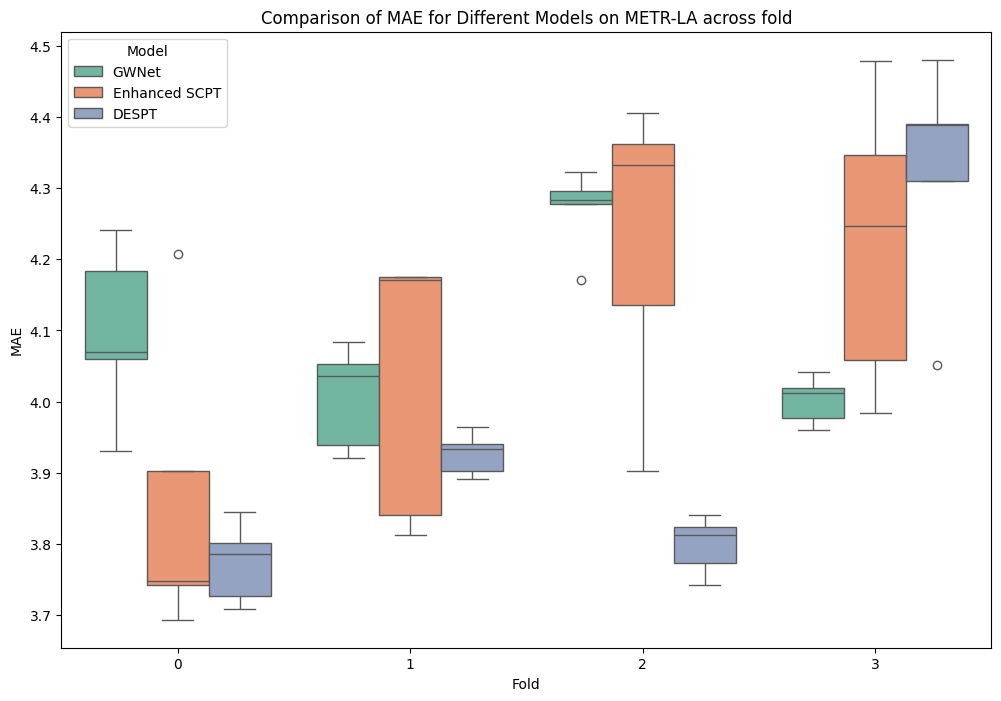

In [24]:
import seaborn as sns

filtered_df = df[df['track_id'].isin([9001, 9002, 9004]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9001: 'GWNet', 9002: 'Enhanced SCPT', 9004: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on METR-LA across fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/2612710303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


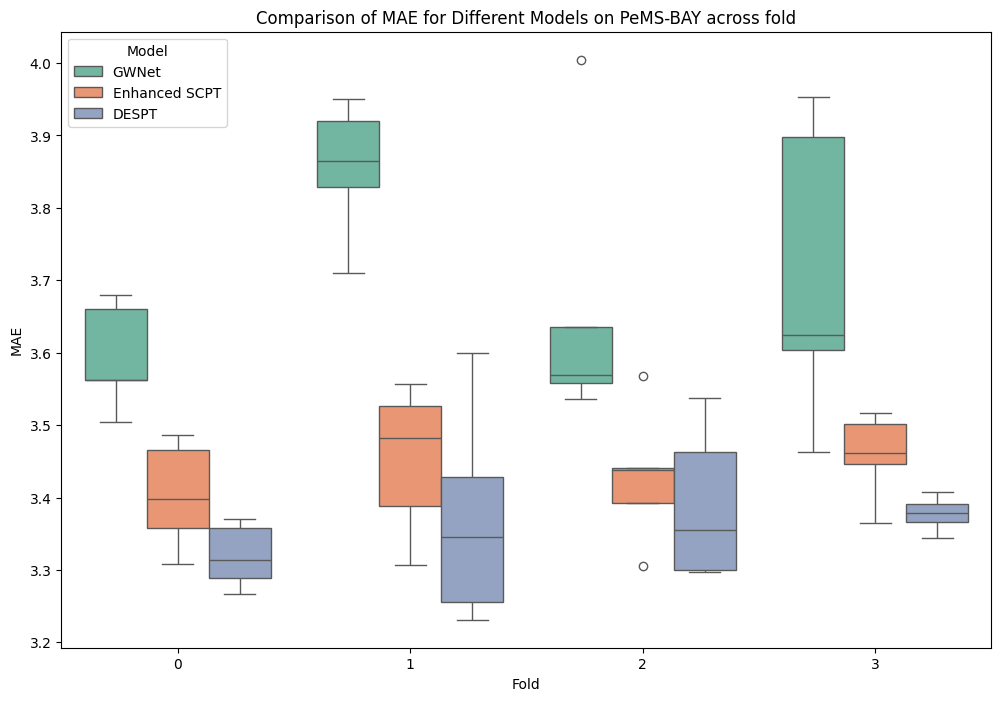

In [25]:
filtered_df = df[df['track_id'].isin([9005, 9006, 9007]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9005: 'GWNet', 9006: 'Enhanced SCPT', 9007: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on PeMS-BAY across fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/68583849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


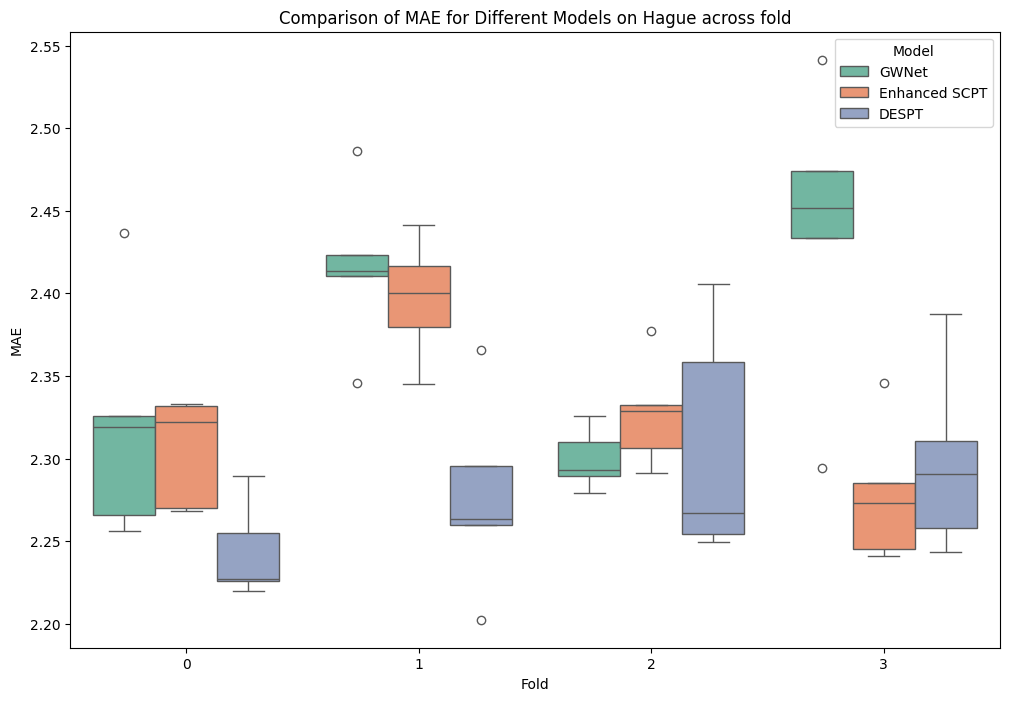

In [38]:
filtered_df = df[df['track_id'].isin([9008, 9009, 9010]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9008: 'GWNet', 9009: 'Enhanced SCPT', 9010: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on Hague across fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/1269486560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


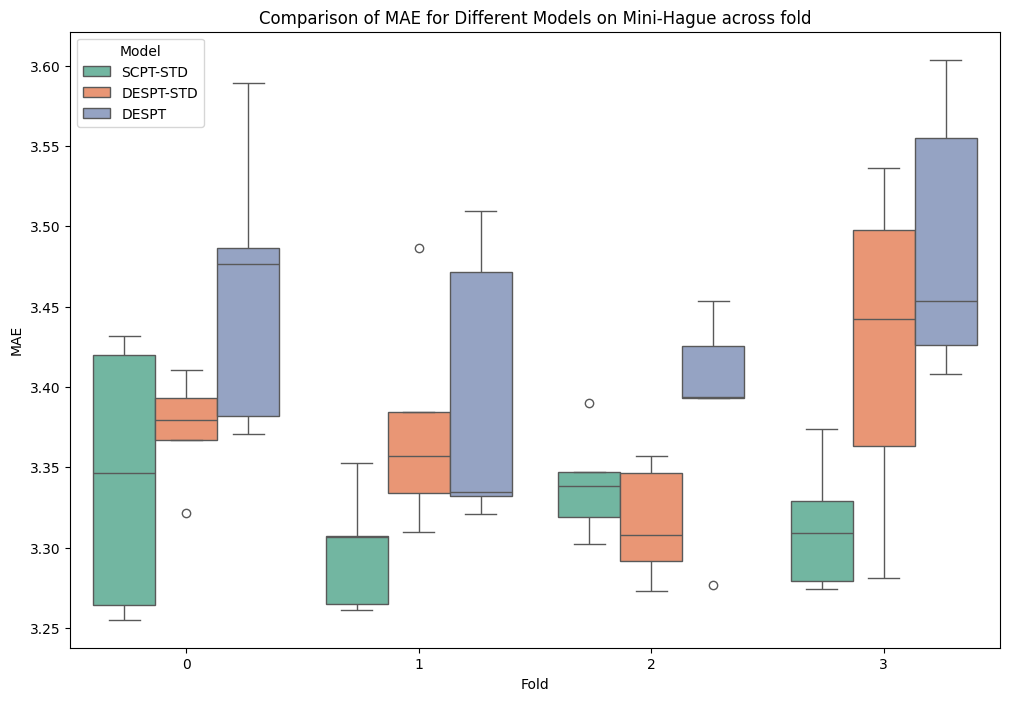

In [51]:
filtered_df = df[df['track_id'].isin([9011, 9012, 9014]) & df['fold_i'].isin([0, 1, 2, 3])]

# Map the track_id to the specified labels
track_id_labels = {9011: 'SCPT-STD', 9012: 'DESPT-STD', 9014: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Create a boxplot for each track_id and fold_i
sns.boxplot(x='fold_i', y='test_a_MAE', hue='track_id', data=filtered_df, palette="Set2")

# Add titles and labels
plt.title('Comparison of MAE for Different Models on Mini-Hague across fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/2931332716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


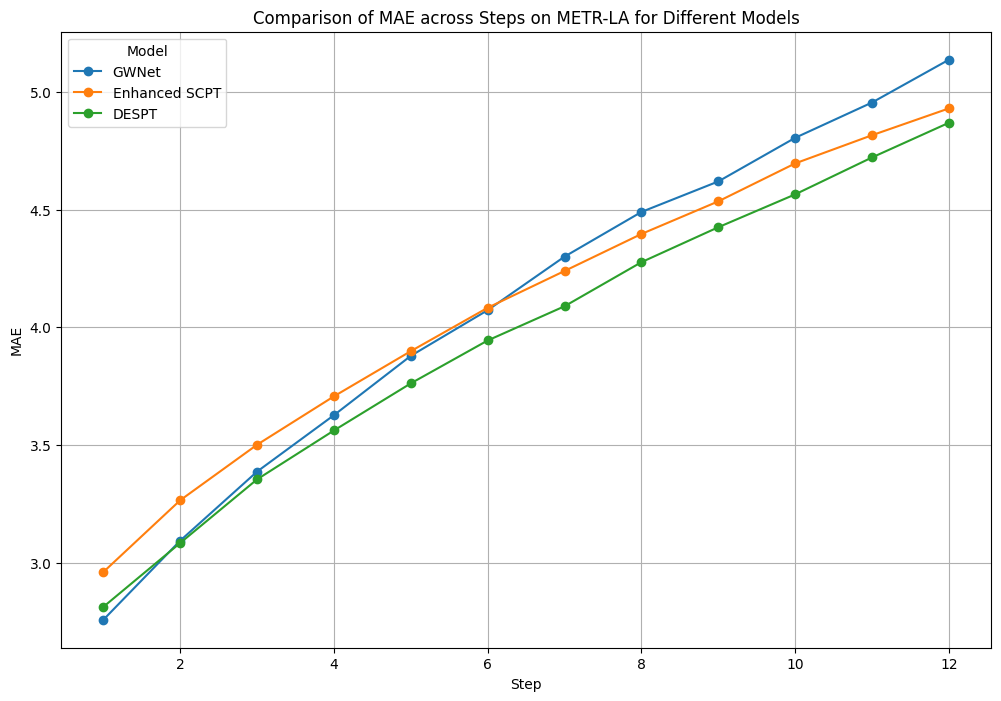

In [42]:
filtered_df = df[df['track_id'].isin([9001, 9002, 9004])]
track_id_labels = {9001: 'GWNet', 9002: 'Enhanced SCPT', 9004: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
steps = [f'step_{i}.MAE' for i in range(1, 13)]
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[steps].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Steps on METR-LA for Different Models')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/3773483112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


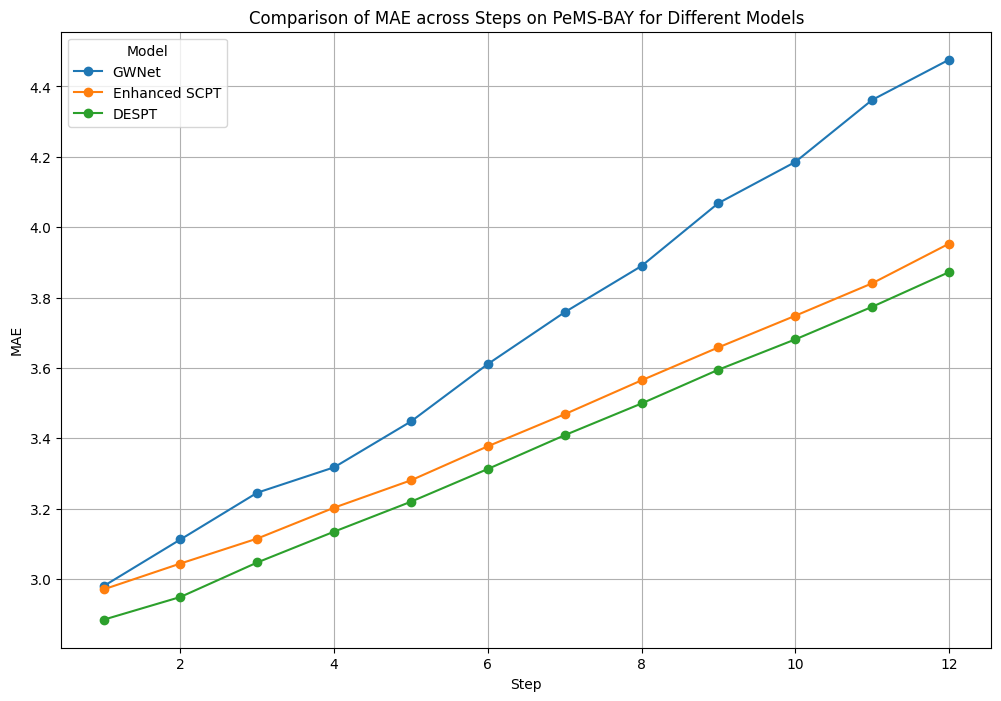

In [45]:
filtered_df = df[df['track_id'].isin([9005, 9006, 9007])]
track_id_labels = {9005: 'GWNet', 9006: 'Enhanced SCPT', 9007: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
steps = [f'step_{i}.MAE' for i in range(1, 13)]
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[steps].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Steps on PeMS-BAY for Different Models')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/3381289692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


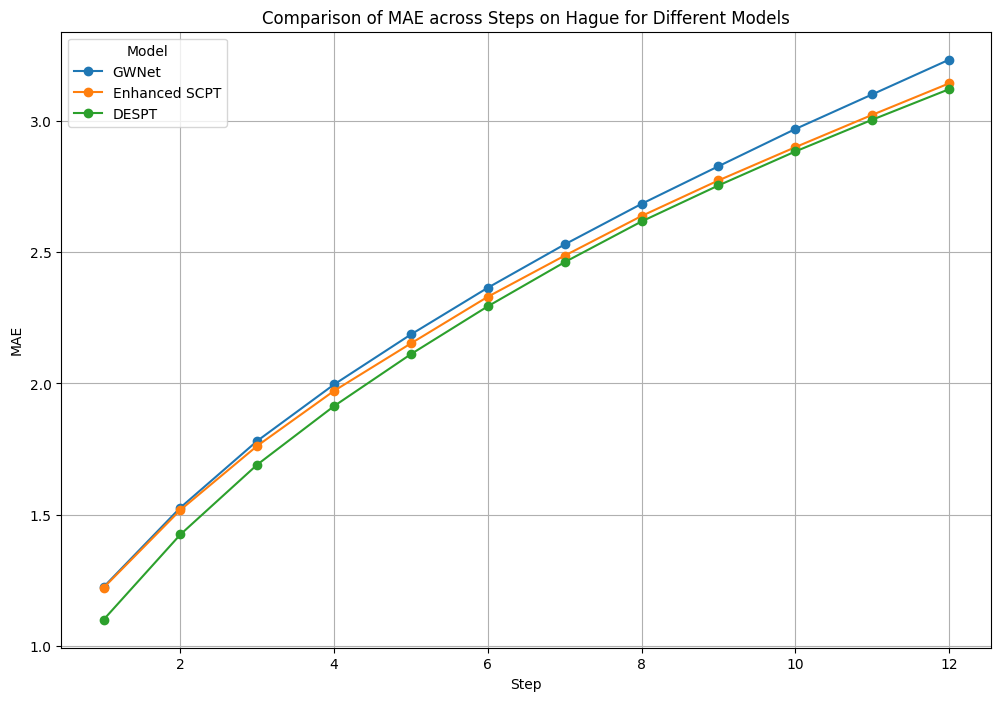

In [46]:
filtered_df = df[df['track_id'].isin([9008, 9009, 9010])]
track_id_labels = {9008: 'GWNet', 9009: 'Enhanced SCPT', 9010: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
steps = [f'step_{i}.MAE' for i in range(1, 13)]
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['GWNet', 'Enhanced SCPT', 'DESPT']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[steps].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Steps on Hague for Different Models')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.grid(True)
plt.show()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_16749/1657320720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)


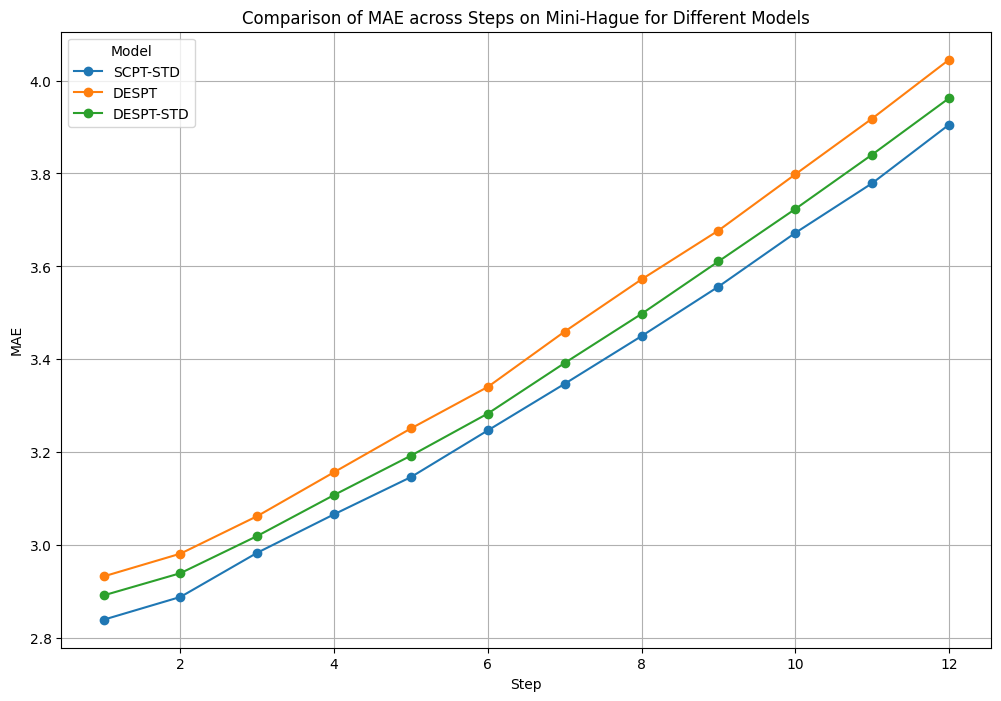

In [52]:
filtered_df = df[df['track_id'].isin([9011, 9012, 9014])]
track_id_labels = {9011: 'SCPT-STD', 9012: 'DESPT-STD', 9014: 'DESPT'}
filtered_df['track_id'] = filtered_df['track_id'].map(track_id_labels)

# Prepare the data for plotting
steps = [f'step_{i}.MAE' for i in range(1, 13)]
step_numbers = list(range(1, 13))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each track_id
for track_id in ['SCPT-STD', 'DESPT', 'DESPT-STD']:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    mean_values = track_data[steps].mean()
    plt.plot(step_numbers, mean_values, marker='o', label=track_id)

# Add titles and labels
plt.title('Comparison of MAE across Steps on Mini-Hague for Different Models')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.legend(title='Model')

# Show the plot
plt.grid(True)
plt.show()

# Load data

In [2]:
df = pd.read_hdf('data/PEMSBAY/PEMS-BAY.h5')
file_path = 'result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/i_tst.txt'
location_df = pd.read_csv('data/PEMSBAY/graph_sensor_locations_bay.csv')

# Read the file
with open(file_path, 'r') as file:
    # Read all lines and convert them to integers
    indexes = np.array([int(line.strip()) for line in file])

In [3]:
indexes

array([185, 309, 220, 112,  11, 150, 234,  85, 246, 134, 143, 271, 182,
       281,   4, 133,  44, 250, 203, 135, 145,  71, 118, 294, 322, 216,
        74, 319, 248,  94, 303,  93,  18, 283, 292,  31, 140,  89, 158,
       286, 141, 243,  13,  77, 311, 179, 177, 200,  33,  62, 122,  54,
       239,  16,  40, 256,  73,   8, 221, 156, 123, 320,  15, 125, 265])

In [5]:
filtered_ids = df.columns[indexes]

# Step 4: Set the index of location_df to 'sensor_id' for reindexing
location_df_new = location_df.set_index('sensor_id', inplace=False)

# Step 5: Filter and reindex the location DataFrame to follow the order of filtered_ids
filtered_locations = location_df_new.loc[filtered_ids].reset_index()
filtered_locations

,sensor_id,latitude,longitude
0,401958,37.270209,-121.860998
1,407374,37.395123,-122.068612
2,402368,37.393954,-122.005269
3,400822,37.255715,-121.955375
4,400084,37.329258,-122.012053
...,...,...,...
60,400907,37.257815,-121.962370
61,413845,37.422887,-121.925747
62,400097,37.279012,-122.010614
63,400916,37.320404,-121.890310


# Map

In [6]:
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Add all locations with blue small dots
for idx, row in location_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=row['sensor_id']
    ).add_to(m)

# Add filtered locations with red small dots
for idx, row in filtered_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=row['sensor_id']
    ).add_to(m)

# Display the map in the notebook
m

In [7]:
YS = torch.load('result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/YS.pt', map_location=torch.device('cpu'))
YS_pred_09 = torch.load('result/9009_r1_f0_PEMSBAY_gwnet_TCN_240710-0235/YS_pred.pt', map_location=torch.device('cpu'))
YS_pred_10 = torch.load('result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/YS_pred.pt', map_location=torch.device('cpu'))

In [8]:
YS.shape, YS_pred_09.shape

(torch.Size([15624, 12, 65, 1]), torch.Size([15624, 12, 65, 1]))

In [9]:
mae_loss_09 = torch.mean(torch.abs(YS - YS_pred_09), dim=(0, 1, 3)).numpy()
mae_loss_10 = torch.mean(torch.abs(YS - YS_pred_10), dim=(0, 1, 3)).numpy()

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping

norm = plt.Normalize(mae_loss_10.min(), mae_loss_10.max())
colormap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

# Add locations with color-coded pins based on MAE loss
for idx, row in filtered_locations.iterrows():
    color = to_hex(colormap.to_rgba(mae_loss_10[idx]))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['sensor_id']}\nMAE: {mae_loss_10[idx]:.4f}"
    ).add_to(m)

# Display the map in the notebook
m

In [26]:
mae_diff_10_09 = mae_loss_10 - mae_loss_09

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping
norm_positive = plt.Normalize(mae_diff_10_09[mae_diff_10_09 > 0].min(), mae_diff_10_09.max())
norm_negative = plt.Normalize(mae_diff_10_09.min(), mae_diff_10_09[mae_diff_10_09 < 0].max())

# Add locations with color-coded pins based on MAE loss
for idx, row in filtered_locations.iterrows():
    if mae_diff_10_09[idx] > 0:
        color = to_hex(plt.cm.YlOrRd(norm_positive(mae_diff_10_09[idx])))  # Yellow to Red for positive
    else:
        color = to_hex(plt.cm.Greens(1 - norm_negative(mae_diff_10_09[idx])))  # More negative, more green

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['sensor_id']}\nMAE Difference: {mae_diff_10_09[idx]:.4f}"
    ).add_to(m)

# Display the map in the notebook
m

unzip the abnormal sensor in temporal 
For dataset, or for contribution purpose

# Prediction performance overtime

In [24]:
mae_loss_per_timestep_09 = torch.mean(torch.abs(YS - YS_pred_09), dim=(1, 2, 3)).numpy()
mae_loss_per_timestep_10 = torch.mean(torch.abs(YS - YS_pred_10), dim=(1, 2, 3)).numpy()

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the MAE values with a moving average
window_size = 100  # You can adjust the window size for more or less smoothing
smoothed_mae_09 = moving_average(mae_loss_per_timestep_09, window_size)
smoothed_mae_10 = moving_average(mae_loss_per_timestep_10, window_size)

# Adjust the x-axis to match the length of the smoothed data
timesteps_09 = np.arange(len(mae_loss_per_timestep_09))
timesteps_10 = np.arange(len(mae_loss_per_timestep_10))
smoothed_timesteps_09 = timesteps_09[window_size-1:]
smoothed_timesteps_10 = timesteps_10[window_size-1:]

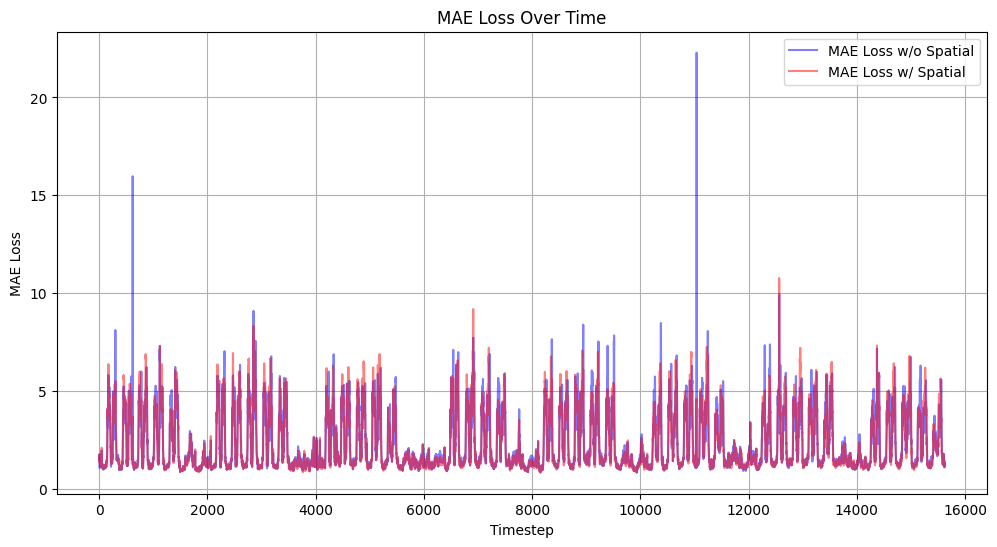

In [22]:
# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 6))
plt.plot(timesteps_09, mae_loss_per_timestep_09, label='MAE Loss w/o Spatial', color='blue', alpha=0.5)
plt.plot(timesteps_10, mae_loss_per_timestep_10, label='MAE Loss w/ Spatial', color='red', alpha=0.5)
plt.xlabel('Timestep')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

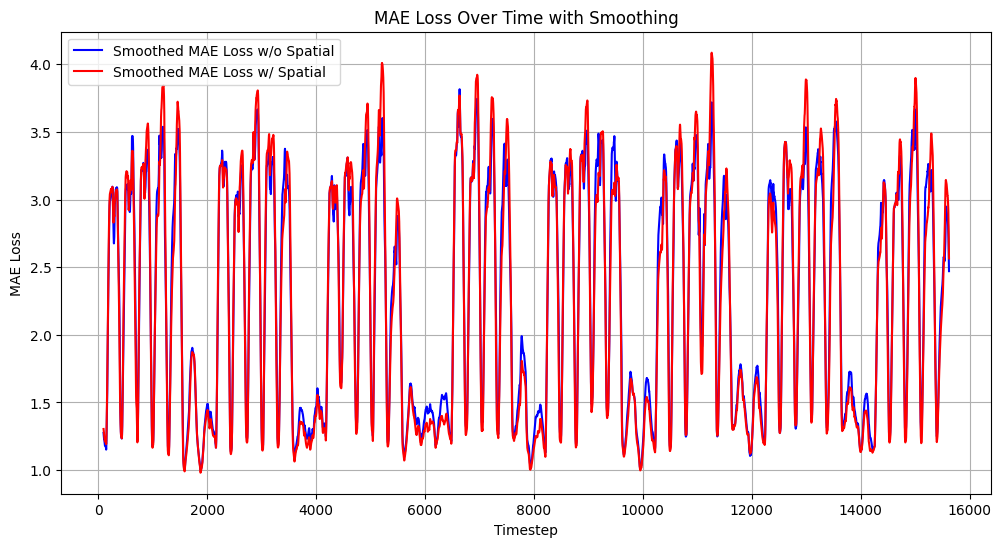

In [25]:

# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 6))
plt.plot(smoothed_timesteps_09, smoothed_mae_09, label='Smoothed MAE Loss w/o Spatial', color='blue')
plt.plot(smoothed_timesteps_10, smoothed_mae_10, label='Smoothed MAE Loss w/ Spatial', color='red')
plt.xlabel('Timestep')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time with Smoothing')
plt.legend()
plt.grid(True)
plt.show()